In [20]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col

from utils import make_precinct_counts,make_demo_map,job_cols,race_cols,cols_to_keep,scale_and_cluster,make_edname,map_round_votes

from shapely import wkt

import seaborn as sns
from sklearn.decomposition import FactorAnalysis
from sklearn.decomposition import PCA
from factor_analyzer import calculate_kmo, calculate_bartlett_sphericity

demo_cluster = pd.read_csv('../../chapter_two/data/occupation_demo_clusters_on_ed.csv')
ed_level = pd.read_csv('../../cc_election_cleaning/occupation_demo_data_feb21.csv')

ed_shapefile = '../../chapter_two/data/nyed_21a/nyed.shp'
ed_gdf = gpd.read_file(ed_shapefile)

full_results = pd.read_csv('../../cc_election_cleaning/election_results_with_vote_sponsor_cluster_FEB13.csv')
sn = full_results[full_results['candidate'] == 'Sandy Nurse']

ae = pd.read_csv('../../cc_election_cleaning/ae_precincts.csv')
av = pd.read_csv('../../cc_election_cleaning/additional_variables.csv')
fwe = pd.read_csv('../data/finance_with_ethnicity.csv')
f_plus = pd.read_csv('../../council_campaign_finance/data/iwrl_plus.csv')
occ_df = pd.read_csv('../../cc_election_cleaning/occupation_election_feb21.csv')

p_cols = [col for col in occ_df.columns if col[-1] == 'p']
wp_cols = [col for col in occ_df.columns if col.startswith("w2") and col.endswith("p")]
wp_cols.remove('w2cop')
to_remove = [ 'w2psp',
 'w2sep',
 'w2npp',
 'w2govp',
 'w2nip']
wp_cols = [col for col in wp_cols if col not in to_remove]
demo_cols = ['nhw21p','nhb21p','h21p','nha21p','cvap21bapp','mhhi21']

sn = gpd.GeoDataFrame(sn,geometry=sn['geometry'].apply(wkt.loads))
sn = sn.set_crs(epsg=2263, allow_override=True)
co_3857 = sn.to_crs(epsg=3857)

In [51]:
import matplotlib.patches as mpatches
import colorsys
from matplotlib.colors import to_hex
import contextily as ctx

In [21]:

import contextily as ctx
import seaborn as sns

In [40]:
aal = pd.read_csv('../../cc_election_cleaning/precincts_leins.csv')

In [3]:
for col in sn:
    if col.startswith('a') and col.endswith('p'):
        print(col)

adams213p


In [59]:
demo_occ = sn[['vote_share','ed_name','nhw21p','nhb21p','h21p','nha21p','cvap21bapp','mhhi21','venez21p','chin21p',
                 'kor21p','colomb21p','domin21p','prican21p','mex21p','white_transplant_ratio','adams213p','winda21p']].merge(occ_df, left_on='ed_name', right_on='ElectDist', how='left')
demo_occ = demo_occ.merge(ae[['ElectDist','ind21p','bang21p','pak21p','filip21p']],on = 'ElectDist',how='left')
demo_occ = demo_occ.merge(av,on='ElectDist',how='left')
demo_occ = demo_occ.merge(aal[['ElectDist','tl_count']], on='ElectDist', how='left')

In [5]:
demo_occ['log_mhhi21'] = np.log(demo_occ['mhhi21'])

In [10]:
test_cols = ['nhw21p','nhb21p','h21p','nha21p','cvap21bapp','log_mhhi21','venez21p','chin21p','kor21p','colomb21p','domin21p','prican21p',
'mex21p','white_transplant_ratio','ind21p','bang21p','pak21p','filip21p','greek21p','arab21p',
'fb21bdp','fb21drp','hh21bop','tl_count','adams213p'] + wp_cols

In [9]:
cor_matrix = demo_occ[test_cols].corr()
cor_matrix.dropna(subset=('vote_share'),inplace=True)
cor_matrix.sort_values(by='vote_share', ascending=False)

vote_share    nhw21p    nhb21p      h21p    nha21p  \
vote_share                1.000000  0.569006 -0.098475 -0.028468 -0.454995   
white_transplant_ratio    0.667688  0.945450 -0.386545 -0.071592 -0.093751   
cvap21bapp                0.667332  0.891866 -0.467175  0.049727 -0.086464   
w2admp                    0.625564  0.742892 -0.252657 -0.078044 -0.128662   
nhw21p                    0.569006  1.000000 -0.449252 -0.085469 -0.006252   
w2cmp                     0.471854  0.475223  0.012471 -0.185845 -0.199467   
kor21p                    0.438395  0.691862 -0.480235  0.131433 -0.002023   
mex21p                    0.406050  0.407324 -0.548250  0.464585 -0.223959   
filip21p                  0.382852  0.614105 -0.391624  0.082896  0.044661   
greek21p                  0.355117  0.478096 -0.276443  0.024954 -0.048965   
w2banp                    0.297562  0.459980 -0.182584 -0.098450  0.041730   
w2mgtp                    0.274953  0.432351 -0.136395 -0.124349 -0.039321   
w2aep                     0.234265  0.184861 -0.259458  0.276965 -0.193489   
w2foodp                   0.194774  0.449899 -0.293198  0.055789  0.020984   
venez21p                  0.181870  0.146200 -0.108499  0.167412 -0.241030   
w2farmp                   0.122163  0.240059  0.054115 -0.171661 -0.085798   
w2prodp                   0.116840  0.225058 -0.150161 -0.017159  0.141148   
w2scip                    0.106422  0.169311 -0.084528  0.024411  0.015430   
arab21p                   0.106404  0.284647 -0.281773  0.117304  0.064996   
w2cossp                   0.101503  0.112427  0.328470 -0.423561  0.002534   
w2lawp                    0.097067  0.019799  0.191709 -0.216726  0.023780   
w2edup                    0.091844 -0.018567  0.103295 -0.046716 -0.133655   
prican21p                 0.076950 -0.057974 -0.377323  0.533540 -0.204781   
log_mhhi21                0.059846  0.121489 -0.035232 -0.112177  0.163950   
colomb21p                 0.036201  0.352668 -0.537503  0.349883  0.164835   
w2oadp                    0.024915 -0.151602  0.219314 -0.102757 -0.049638   
w2docp                    0.005839 -0.017461  0.085199 -0.024385 -0.078154   
h21p                     -0.028468 -0.085469 -0.767590  1.000000 -0.233857   
w2copp                   -0.050109 -0.196364  0.259685 -0.280797  0.195274   
pak21p                   -0.095434 -0.073401  0.013929 -0.021026  0.189017   
nhb21p                   -0.098475 -0.449252  1.000000 -0.767590 -0.153158   
w2emrp                   -0.126309 -0.048212 -0.204790  0.159807  0.226445   
w2ffp                    -0.128019 -0.410194  0.392885 -0.043656 -0.327921   
w2hsp                    -0.138475 -0.373956  0.216599  0.041704 -0.173143   
w2conp                   -0.197748 -0.197663 -0.176718  0.263662  0.181727   
chin21p                  -0.216049 -0.035080 -0.315652  0.157776  0.604525   
tl_count                 -0.217718 -0.369883  0.187343  0.002236 -0.119753   
w2bgp                    -0.219232 -0.258812 -0.056627  0.185934  0.106946   
fb21drp                  -0.246347 -0.454679 -0.139057  0.498043 -0.145245   
hh21bop                  -0.246809 -0.434786  0.152113  0.032348  0.108018   
adams213p                -0.247478 -0.781289  0.673185 -0.100946 -0.425406   
w2salep                  -0.270366 -0.222861 -0.076639  0.081198  0.293953   
domin21p                 -0.281938 -0.488305 -0.179067  0.554058 -0.157574   
w2matp                   -0.282704 -0.426900 -0.163350  0.427084 -0.022067   
w2htp                    -0.303721 -0.185939  0.098088 -0.167629  0.351853   
w2pservep                -0.430932 -0.222893  0.220020 -0.325264  0.455630   
nha21p                   -0.454995 -0.006252 -0.153158 -0.233857  1.000000   
bang21p                  -0.488531 -0.245706  0.257997 -0.402722  0.622407   
ind21p                   -0.513676 -0.162852  0.083041 -0.371702  0.852024   
w2tranp                  -0.520496 -0.346316  0.135203 -0.114987  0.407092   
fb21bdp                  -0.537716 -0.193206  

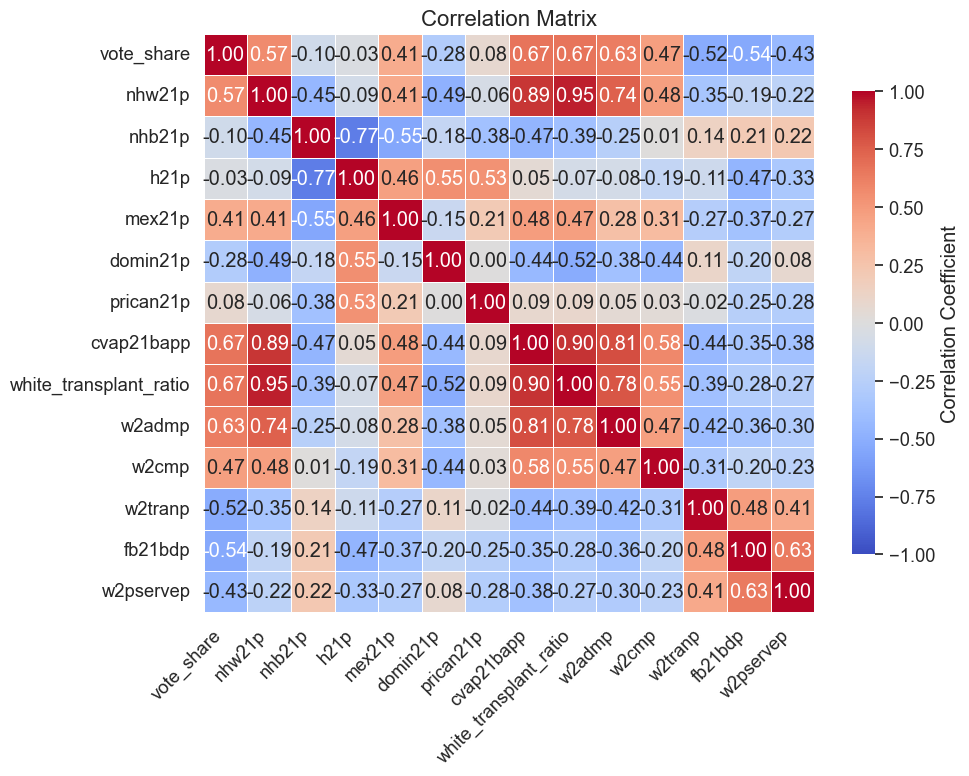

In [18]:
small_cor_cols = ['vote_share','nhw21p','nhb21p','h21p','mex21p','domin21p','prican21p','cvap21bapp','white_transplant_ratio','w2admp','w2cmp','w2tranp','fb21bdp','w2pservep']
small_cor_matrix = demo_occ[small_cor_cols].corr()
small_cor_matrix.dropna(subset=('vote_share'),inplace=True) 
#small_cor_matrix.rename(index=label_map, columns=label_map, inplace=True)

plt.figure(figsize=(10, 8))
sns.set(style="white", font_scale=1.2)

heatmap = sns.heatmap(
    small_cor_matrix,
    annot=True,             
    fmt=".2f",             
    cmap="coolwarm",        
    vmin=-1, vmax=1,        
    linewidths=0.5,         
    cbar_kws={"shrink": 0.8, 'label': 'Correlation Coefficient'}
)

plt.title("Correlation Matrix", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [11]:
kmo_all, kmo_model = calculate_kmo(demo_occ[test_cols])
chi_square_value, p_value = calculate_bartlett_sphericity(demo_occ[test_cols])

print("KMO per item:", kmo_all)
print("Overall KMO:", kmo_model)       
print("Bartlett’s test χ²:", chi_square_value, "p-value:", p_value) 

KMO per item: [0.60094748 0.4720394  0.34312772 0.35297538 0.59807038 0.50391513
 0.22922311 0.16297829 0.5747347  0.23287512 0.36743231 0.15119897
 0.37508848 0.56024177 0.3897018  0.43357667 0.18363853 0.52708541
 0.53940695 0.26557712 0.67707141 0.6271476  0.45513794 0.38320025
 0.58698546 0.27883082 0.26312394 0.42875506 0.41163037 0.26825868
 0.25802252 0.26402379 0.11596018 0.63481826 0.09694056 0.39027222
 0.50101686 0.37003624 0.33189065 0.46451702 0.3536496  0.50353582
 0.29000322 0.40182695 0.27437454 0.33444124 0.30029432 0.18489281
 0.35017334 0.35695037]
Overall KMO: 0.39091746083890155
Bartlett’s test χ²: 6287.544570419256 p-value: 0.0


In [12]:
def iterative_kmo_prune(df, threshold_item=0.50, threshold_overall=0.60):
    from factor_analyzer import calculate_kmo
    df_current = df.copy()
    while True:
        kmo_items, kmo_overall = calculate_kmo(df_current)
        worst_idx = kmo_items.argmin()
        if (kmo_overall >= threshold_overall and 
            all(kmo_items >= threshold_item)):
            break
        drop_var = df_current.columns[worst_idx]
        print(f"Dropping '{drop_var}' (KMO={kmo_items[worst_idx]:.3f}); new overall KMO before recalculation = {kmo_overall:.3f}")
        df_current = df_current.drop(columns=[drop_var])
    return df_current

In [13]:
pruned_df = iterative_kmo_prune(demo_occ[test_cols])

Dropping 'w2docp' (KMO=0.097); new overall KMO before recalculation = 0.391
Dropping 'w2edup' (KMO=0.119); new overall KMO before recalculation = 0.428
Dropping 'w2farmp' (KMO=0.218); new overall KMO before recalculation = 0.489
Dropping 'prican21p' (KMO=0.202); new overall KMO before recalculation = 0.484
Dropping 'w2scip' (KMO=0.177); new overall KMO before recalculation = 0.515
Dropping 'w2prodp' (KMO=0.238); new overall KMO before recalculation = 0.530
Dropping 'chin21p' (KMO=0.247); new overall KMO before recalculation = 0.545
Dropping 'w2lawp' (KMO=0.274); new overall KMO before recalculation = 0.553
Dropping 'pak21p' (KMO=0.301); new overall KMO before recalculation = 0.558
Dropping 'arab21p' (KMO=0.289); new overall KMO before recalculation = 0.556
Dropping 'w2cossp' (KMO=0.369); new overall KMO before recalculation = 0.592
Dropping 'w2copp' (KMO=0.377); new overall KMO before recalculation = 0.601
Dropping 'w2conp' (KMO=0.414); new overall KMO before recalculation = 0.625
Drop

In [14]:
predictors = pruned_df.columns.tolist()
X = demo_occ[predictors]

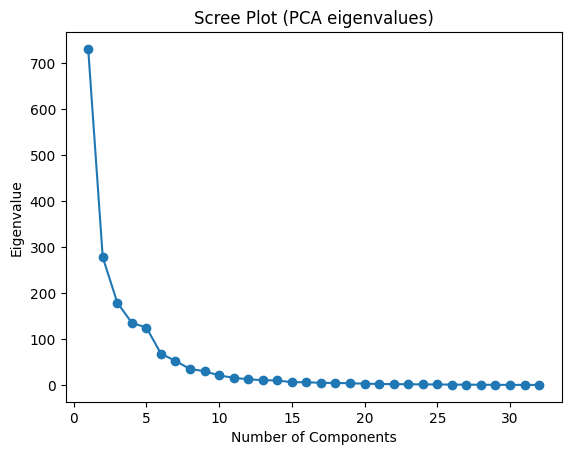

In [15]:
pca = PCA()
pca.fit(X)

ev = pca.explained_variance_

plt.plot(range(1, len(ev) + 1), ev, marker='o')
plt.title('Scree Plot (PCA eigenvalues)')
plt.xlabel('Number of Components')
plt.ylabel('Eigenvalue')
plt.show()

In [16]:
n_factors = 4
fa = FactorAnalysis(n_components=n_factors, random_state=0)
factor_scores = fa.fit_transform(X)

In [17]:
fa_df = pd.DataFrame(
    factor_scores,
    columns=[f'Factor{i+1}' for i in range(n_factors)],
    index=demo_occ.index
)

In [18]:
loadings = pd.DataFrame(
    fa.components_.T,
    index=predictors,
    columns=fa_df.columns
)
print("Factor Loadings:\n", loadings)

Factor Loadings:
                           Factor1    Factor2    Factor3   Factor4
nhw21p                  -5.720190   5.367901   1.318882 -1.995765
nhb21p                  10.072551  -5.381529  11.823748 -3.102089
nha21p                   2.792659   3.669791  -1.969998 -0.002679
cvap21bapp              -8.129159   5.323111   1.718661 -2.120227
kor21p                  -0.221446   0.161937   0.001972 -0.032402
colomb21p               -0.343409   0.200092  -0.303044  0.080010
domin21p                 0.647828  -6.007321  -6.352803 -2.632199
mex21p                  -3.013219   0.889458  -0.601532  1.248234
white_transplant_ratio  -3.568597   2.817306   1.243901 -1.097864
ind21p                   2.521941   1.906494  -0.944311 -0.278860
bang21p                  1.035761   0.536247  -0.060944  0.091311
filip21p                -0.305981   0.240090  -0.015776 -0.086102
greek21p                -0.058146   0.050326   0.016561  0.009331
fb21bdp                  3.906877   2.751992  -0.680331 -0

In [19]:
Y = demo_occ['vote_share']
model_fa = sm.OLS(Y, sm.add_constant(fa_df)).fit()
print(model_fa.summary())

                            OLS Regression Results                            
Dep. Variable:             vote_share   R-squared:                       0.628
Model:                            OLS   Adj. R-squared:                  0.613
Method:                 Least Squares   F-statistic:                     40.97
Date:                Wed, 03 Sep 2025   Prob (F-statistic):           4.56e-20
Time:                        15:36:55   Log-Likelihood:                -391.21
No. Observations:                 102   AIC:                             792.4
Df Residuals:                      97   BIC:                             805.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         47.0450      1.138     41.349      0.0

In [22]:
demo_occ['factor1'] = fa_df['Factor1']
demo_occ['factor2'] = fa_df['Factor2']
demo_occ['factor3'] = fa_df['Factor3']
demo_occ['factor4'] = fa_df['Factor4']
demo_occ['factor5'] = fa_df['Factor5']

In [23]:
demo_occ_map = gpd.GeoDataFrame(demo_occ,geometry=demo_occ['geometry_x'].apply(wkt.loads))

Text(0.5, 1.0, 'Vote Share by Election District')

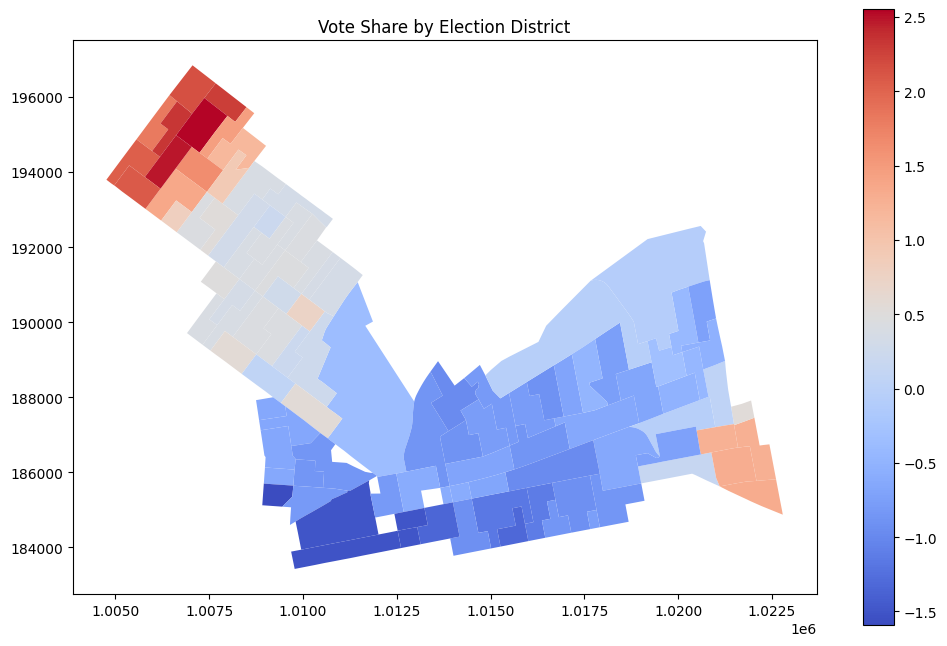

In [31]:
demo_occ_map.plot(column='factor2', cmap='coolwarm', legend=True, figsize=(12, 8))
plt.title('Vote Share by Election District')

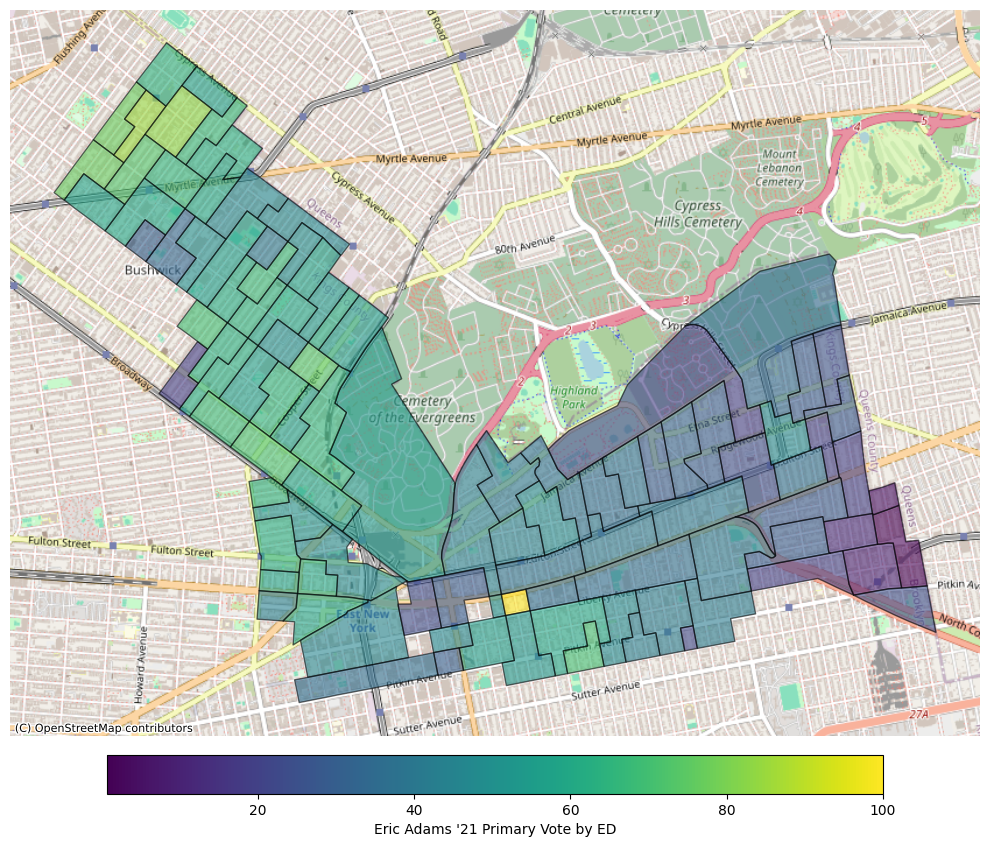

In [77]:
fig, ax = plt.subplots(figsize=(10, 10))
co_3857.plot(
    column="vote_share",
    legend=True,
    legend_kwds={
        "label": "Eric Adams '21 Primary Vote by ED",
        "orientation": "horizontal",
        "shrink": 0.8,        
        "pad": 0.02            
    },
    ax=ax,
    alpha=0.6,
    edgecolor="k",
    cmap="viridis",
)

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_axis_off()
plt.tight_layout()
plt.show()

In [84]:
demo_occ_map = gpd.GeoDataFrame(demo_occ,geometry=demo_occ['geometry_x'].apply(wkt.loads))

In [85]:
gdf = demo_occ_map.copy()

In [86]:
gdf['nbb'] = gdf['nhb21p'] - gdf['winda21p']

In [87]:
eth_cols = ['ind21p','bang21p','domin21p','venez21p','mex21p','white_transplant_ratio','winda21p','nbb']
red_eth_cols = ['nhw21p','nhb21p','h21p','nha21p']

In [48]:
gdf[eth_cols].describe()

ind21p     bang21p    domin21p    venez21p      mex21p  \
count  102.000000  102.000000  102.000000  102.000000  102.000000   
mean     1.925930    0.586460   17.232371    0.310284    6.073446   
std      3.490378    1.499415    9.358422    0.457214    5.005961   
min      0.000000    0.000000    1.667174    0.000000    0.000000   
25%      0.216097    0.000000    9.058785    0.000000    1.802334   
50%      0.742172    0.000000   15.108429    0.046036    5.008067   
75%      1.899080    0.000000   24.014127    0.410959    9.803735   
max     17.871257    9.562564   38.602114    1.712349   20.835518   

       white_transplant_ratio      nhb21p  
count              102.000000  102.000000  
mean                 4.838103   28.271735  
std                  5.034626   17.029663  
min                  0.000000    1.994181  
25%                  0.745278   14.146635  
50%                  1.855895   26.757644  
75%                  8.222806   41.102657  
max                 19.109543   86.662624

In [88]:
gdf['laptop'] = gdf['w2admp'] + gdf['w2banp'] + gdf['w2cmp']

In [89]:
gdf['dom_eth']   = gdf[eth_cols].idxmax(axis=1)  
gdf['dom_eth_p'] = gdf[eth_cols].max(axis=1)     

gdf['dom_red_eth']   = gdf[red_eth_cols].idxmax(axis=1)
gdf['dom_red_eth_p'] = gdf[red_eth_cols].max(axis=1)

gdf['dom_occ']   = gdf[wp_cols].idxmax(axis=1)
gdf['dom_occ_p'] = gdf[wp_cols].max(axis=1)

In [52]:
def make_distinct_colormap(categories, palette_name='tab20'):
    """
    Returns dict mapping each category to a hex color, 
    drawn from Matplotlib’s qualitative palette.
    """
    n = len(categories)
    # grab n distinct colors from the palette
    palette = plt.get_cmap(palette_name).colors
    if n > len(palette):
        raise ValueError(f"Palette {palette_name} only has {len(palette)} colors")
    colors = palette[:n]
    return dict(zip(categories, (to_hex(c) for c in colors)))

eth_colors = make_distinct_colormap(sorted(gdf['dom_eth'].unique()), 'tab20')
occ_colors = make_distinct_colormap(sorted(gdf['dom_occ'].unique()), 'tab20')

# 2) map them into new columns on your GeoDataFrame
gdf['eth_color'] = gdf['dom_eth'].map(eth_colors)
gdf['occ_color'] = gdf['dom_occ'].map(occ_colors)

def pct_to_color(hue, pct):
    """
    Convert hue [0–1] & pct [0–100] to an RGB hex.
    We fix saturation=0.7 and vary value/lightness between 0.4 and 1.
    """
    sat = 0.7
    # map 0–100 → 0.4–1.0
    val = 0.4 + 0.6*(pct/100)
    r, g, b = colorsys.hsv_to_rgb(hue, sat, val)
    return (r, g, b)

In [90]:
gdf = gdf.set_crs(epsg=2263, allow_override=True)
gdf_3857 = gdf.to_crs(epsg=3857)

In [91]:
occ_label_map = {
    'w2admp': 'Designers & Journalists',
    'w2banp': 'Analyst Specialist',
    'w2bgp': 'Janitorial',
    'w2conp': 'Construction',
    'w2copp': 'Law Enforcement',
    'w2foodp': 'Food Service',
    'w2hsp': 'Homecare',
    'w2mgtp': 'Management',
    'w2oadp': 'Office Admin',
    'w2salep': 'Sales'
}

gdf_3857['occupation_label'] = gdf_3857['dom_occ'].map(occ_label_map)
gdf_3857['occupation_label'] = gdf_3857['occupation_label'].astype('category')

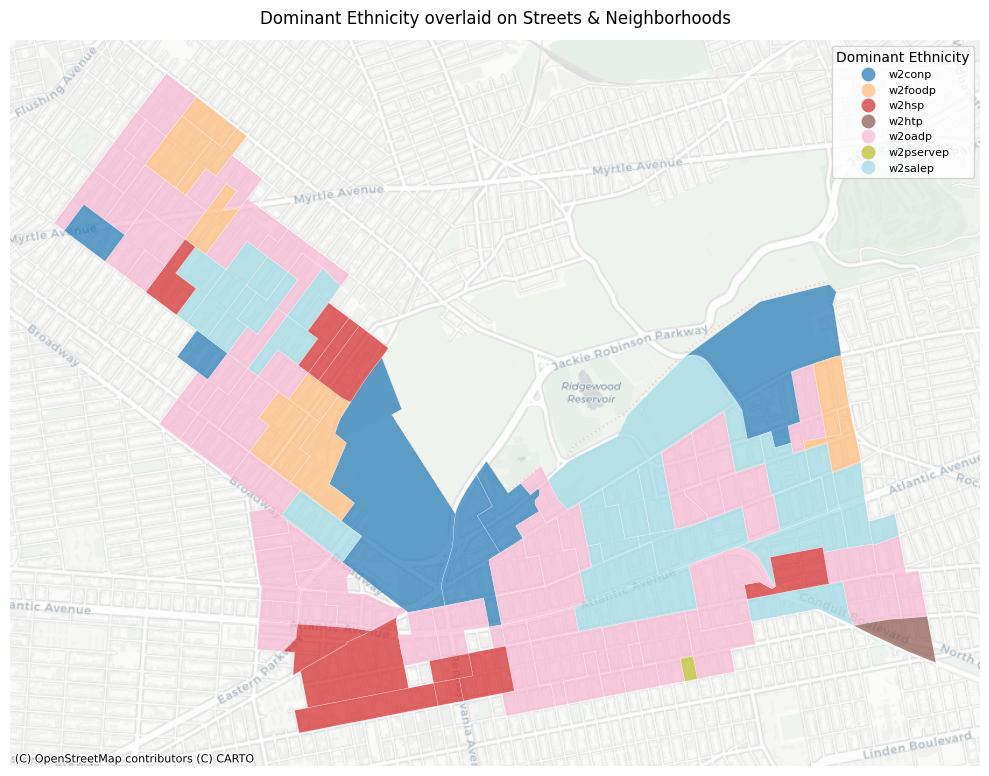

In [94]:
fig, ax = plt.subplots(figsize=(10, 10))

gdf_3857.plot(
    column='dom_occ',
    categorical=True,
    cmap='tab20',
    legend=True,
    alpha=0.7,
    ax=ax,
    edgecolor='white',
    linewidth=0.2,
    legend_kwds={'title': 'Dominant Ethnicity', 'fontsize': 8, 'title_fontsize': 10}
)


ctx.add_basemap(
    ax,
    source=ctx.providers.CartoDB.Positron,  
    zoom=14   
)

# 5) Clean up
ax.set_axis_off()
ax.set_title("Dominant Ethnicity overlaid on Streets & Neighborhoods", pad=12)

plt.tight_layout()
plt.show()

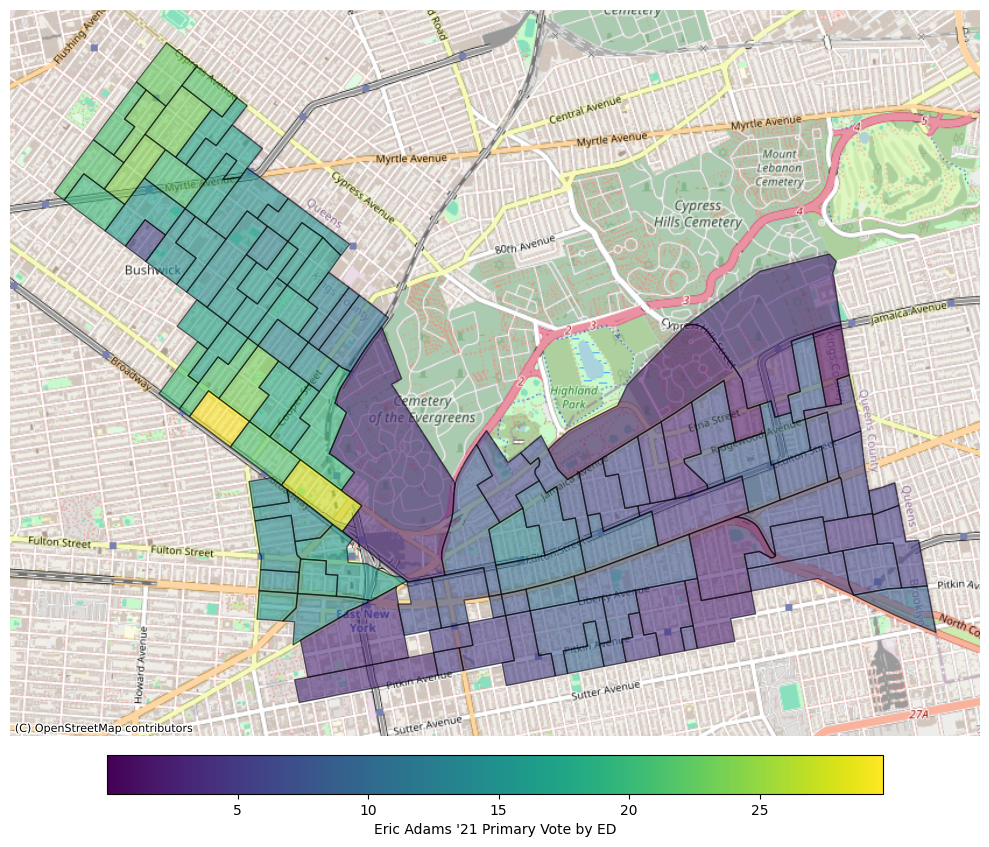

In [98]:
fig, ax = plt.subplots(figsize=(10, 10))
gdf_3857.plot(
    column="laptop",
    legend=True,
    legend_kwds={
        "label": "Eric Adams '21 Primary Vote by ED",
        "orientation": "horizontal",
        "shrink": 0.8,        
        "pad": 0.02            
    },
    ax=ax,
    alpha=0.6,
    edgecolor="k",
    cmap="viridis",
)

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_axis_off()
plt.tight_layout()
plt.show()